## Import

In [1]:
from lightkurve import search_targetpixelfilepixelfile
import numpy as np

## Download pixelfile
Most of the pixelfile are 5x5 pixels

In [7]:
# "KIC 8462852": one the stars that Kepler discovered. We add the prefix KIC as we have data from different telescopes such as Kepler or Tess 
# quarter = 16: get the image pixels of 4 years as every year has 4 quarters
pixelfile = search_targetpixelfile("KIC 8462852", quarter=16).download(quality_bitmask='hardest')

In [6]:
pixelfile

KeplerTargetPixelFile Object (ID: 8462852)

<AxesSubplot:title={'center':'Target ID: 8462852, Cadence: 66714'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

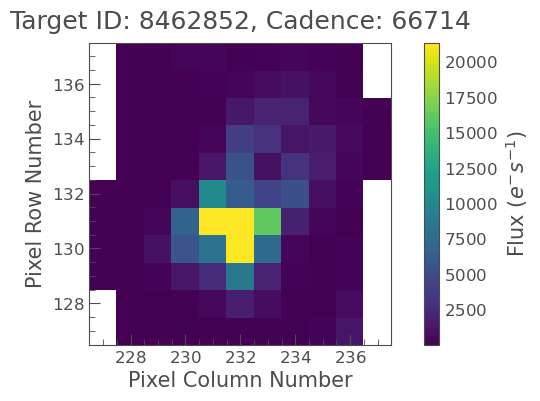

In [8]:
# plot the first frame of the pixelfile
pixelfile.plot(frame=1)

## Convert the pixelfile into a lightcurve

In [ ]:
lc = pixelfile.to_lightcurve(aperture_mask='all')

In [10]:
lc.head()

time,flux,flux_err,centroid_col,centroid_row,cadenceno,quality
,electron / s,electron / s,pix,pix,,
object,float32,float32,float64,float64,int32,int32
1472.1177793449679,258645.03125,18.723051071166992,232.4673225194163,131.64635857207662,66713,0
1472.1382122338982,258660.046875,18.72334861755371,232.46713830837382,131.6455330726855,66714,0
1472.1586449230672,258690.078125,18.723417282104492,232.46697760340683,131.64547910884713,66715,0
1472.1790778124705,258683.328125,18.72397232055664,232.4667835196477,131.6450059544145,66716,0
1472.1995106019822,258655.40625,18.723506927490234,232.46657663040287,131.64489905025656,66717,0


In [11]:
lc.info()

<KeplerLightCurve length=3161>
    name      dtype      unit      class  
------------ ------- ------------ --------
        time  object                  Time
        flux float32 electron / s Quantity
    flux_err float32 electron / s Quantity
centroid_col float64          pix Quantity
centroid_row float64          pix Quantity
   cadenceno   int32               QColumn
     quality   int32               QColumn


- lc.time: time
- lc.flux: flux/brightness of the star

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

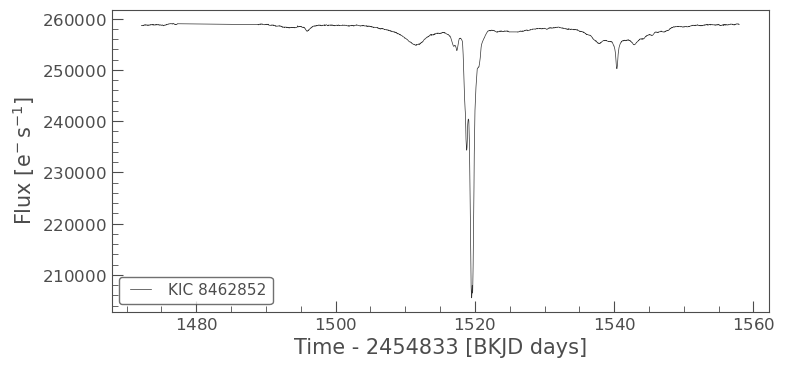

In [12]:
lc.plot()

## Exploring another star

In [16]:
# Download the pixelfile of a planet that, at quarter 4, was already discover 
pixelfile_2 = search_targetpixelfile("KIC 6922244", quarter=4).download_all()

In [17]:
pixelfile_2

TargetPixelFileCollection of 4 objects:
    0: KeplerTargetPixelFile Object (ID: 6922244)
    1: KeplerTargetPixelFile Object (ID: 6922244)
    2: KeplerTargetPixelFile Object (ID: 6922244)
    3: KeplerTargetPixelFile Object (ID: 6922244)

In [18]:
pixelfile_2[1]

KeplerTargetPixelFile Object (ID: 6922244)

In [24]:
# Convert pixelfile to lightcurve
## aperture_mask: a technique used in astronomy to make the image better and easier to analyze
lc_2_3 = pixelfile_2[3].to_lightcurve(aperture_mask=pixelfile_2[3].pipeline_mask)

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

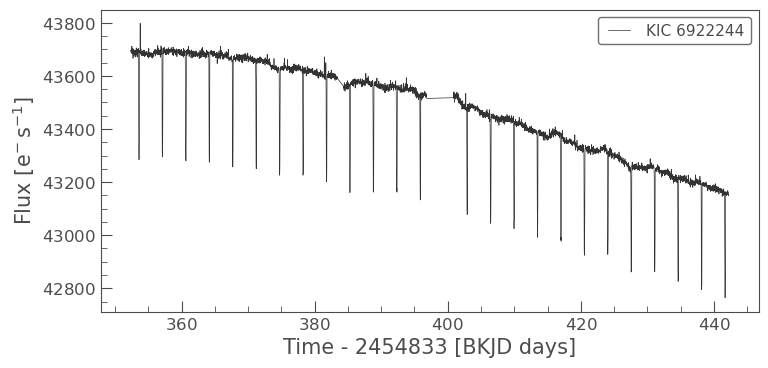

In [25]:
lc_2_3.plot()

Notes:
- we see something periodic
- the star brightness is dropping
 --> could be a variable star
 or due to the telescope that is moving. At time (around 400 on the x-axis), we see no data; the telescope is probably shifting 

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

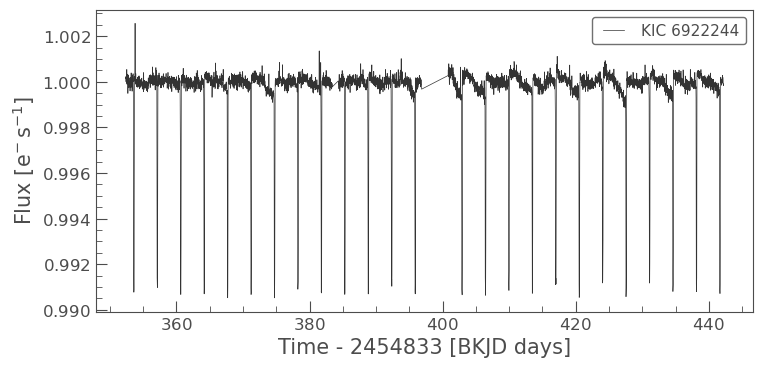

In [26]:
# Flatten the plot to analyze easier
flat_lc_2_3 = lc_2_3.flatten(window_length=401)
flat_lc_2_3.plot()

Notes:
- Brightness periodically drops as a planet transits
- by observing the periodic drop, we can infer how often a planet transits in front of the star.
- the drop m can help us infer the size of the planet

In [27]:
# For easier analysis, we can put each peridic drop on top of one another
folded_lc_2_3 = flat_lc_2_3.fold(period=3.5225) # 3.5225 = days that the planet takes to cross the star

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

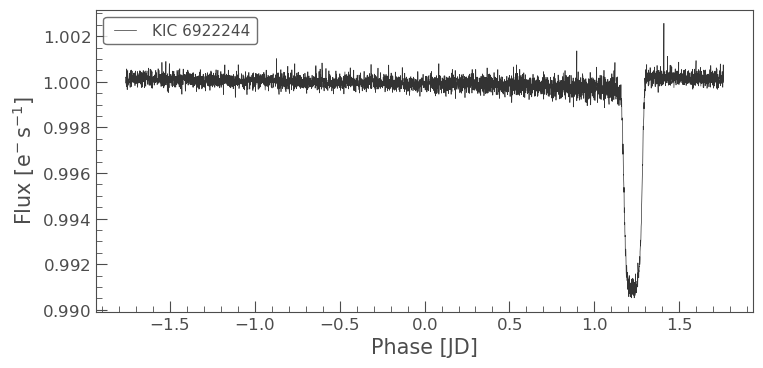

In [28]:
# Plot to show how the planet crosses the star
folded_lc_2_3.plot()

Notes: we can get a lot of information out of this graph like
- the size of the planet by looking at the change in luminosity
- other info  based by looking at how fast this curve changes

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

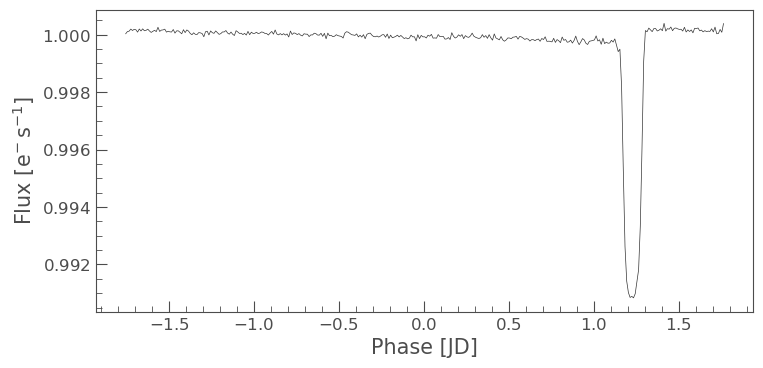

In [50]:
# We can also average the values to make the plot better
# instead of taking every time point
# useful when we 
binned_lc_2_3 = folded_lc_2_3.bin(time_bin_size=0.01)
binned_lc_2_3.plot()

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

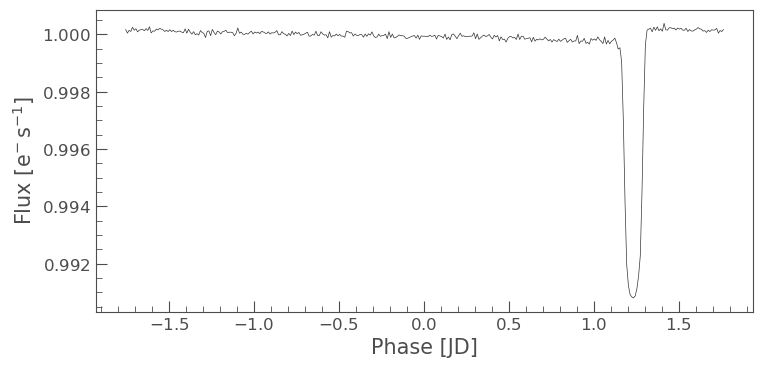

In [51]:
# We can use this code to do everything at once
# and also remove the unusual data (outliers)
lc_2_3.remove_nans().flatten(window_length=401).fold(period=best_fit_period).bin(time_bin_size=0.01).plot()

## How to compute the transit period
= days that a planet takes to cross a star

--> by using a periodogram: produces a frequency graph
that shows all the possible repetitive patterns in your graph
and then tells you what it's most likely to be the most periodic

In [35]:
periodogram = flat_lc_2_3.to_periodogram(method="bls", period=np.arange(0.5, 10, 0.001))

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

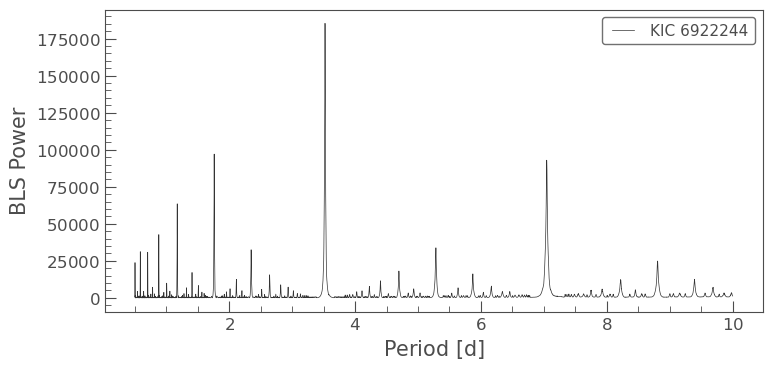

In [36]:
periodogram.plot()

Notes:
- the periodogram shows all the possible frequencies
- the highest frequency is the most repetitive in the flat graph (this is the planet transit in this case)

In [38]:
best_fit_period = periodogram.period_at_max_power
print(f"Best fit period: {best_fit_period: .5f}")

Best fit period:  3.52200 d


## More complex analysis

In [52]:
search_result = search_targetpixelfile('Pi Mensae', mission='TESS', sector=1)
tpf = search_result.download(quality_bitmask='default')

/Users/derrickvanfrausum/anaconda3/envs/astro/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [54]:
print(tpf.mission)
print(tpf.targetid)

TESS
261136679


<AxesSubplot:title={'center':'Target ID: 261136679, Cadence: 70445'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

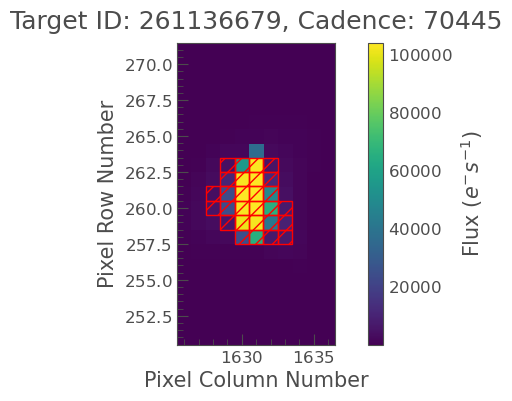

In [55]:
tpf.plot(aperture_mask=tpf.pipeline_mask)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

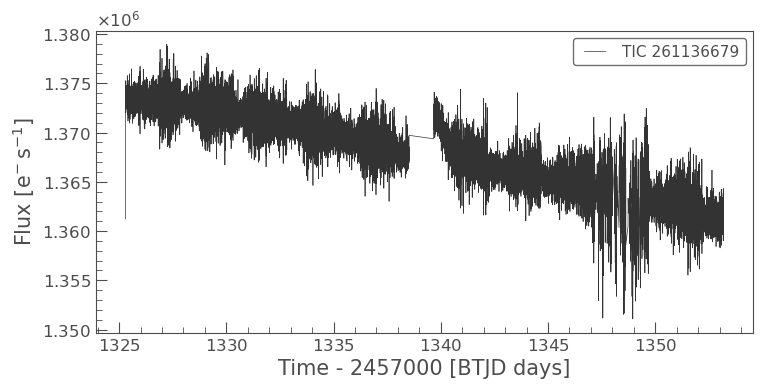

In [56]:
lc = tpf.to_lightcurve()
lc.plot()

Notes:
- this is lightcurve of a star
- where can we see the planet? We would think it is maybe where the drop in luminosity.
- but it is due to Kepler moving => very unstable curves (the pikes just before 1350 on x-axis)
- => we'll want to remove this part from the graph

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

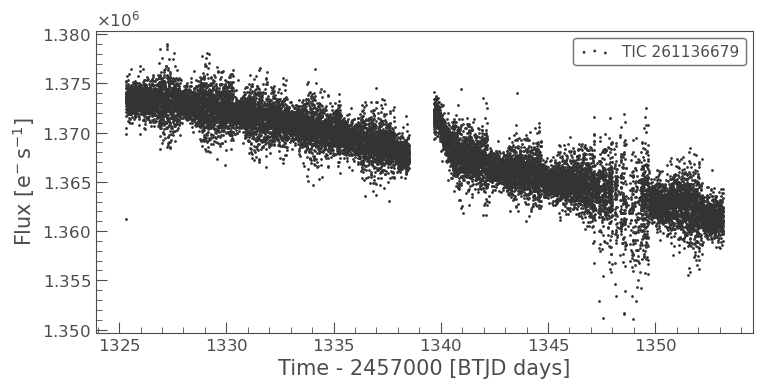

In [57]:
# Recommended plot: 
# easier to analyze (as we can see the amount of stuff going up or down)
lc.scatter()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

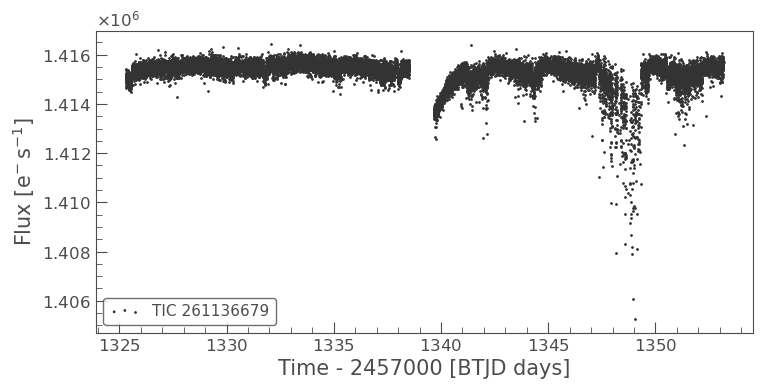

In [59]:
# aperture_mask to make the graph easier to analyze (see tutorials for explanation)
aperture_mask = tpf.create_threshold_mask(threshold=10)
lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
lc.scatter()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

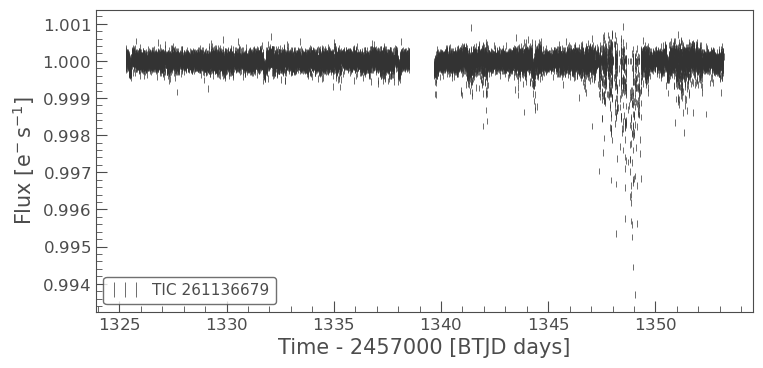

In [60]:
flat_lc = lc.flatten(window_length=1001)
flat_lc.errorbar()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

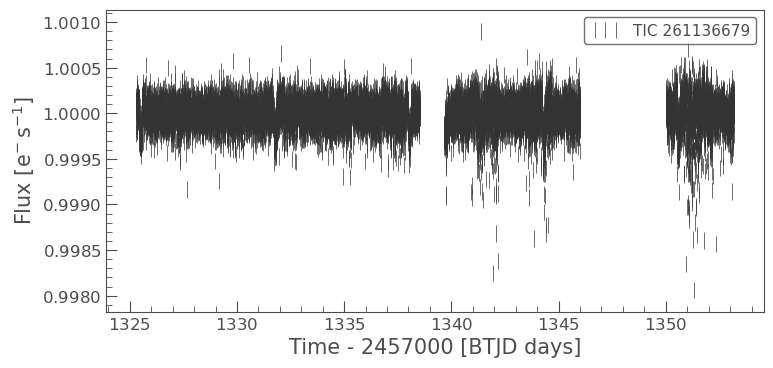

In [66]:
# to remove the not informative pikes
mask = (flat_lc.time.value < 1346) | (flat_lc.time.value > 1350)
masked_lc = flat_lc[mask]
masked_lc.errorbar()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

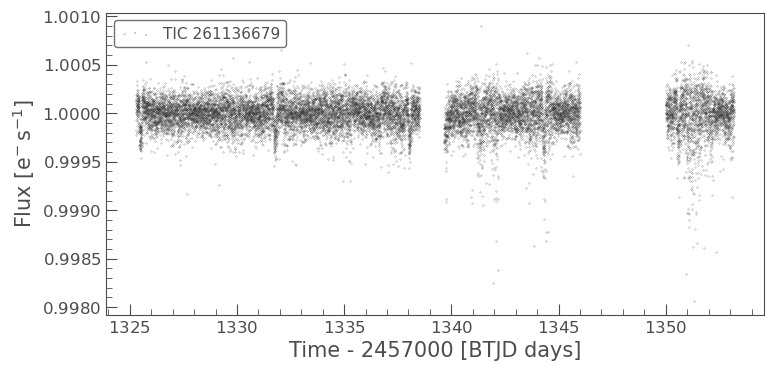

In [69]:
masked_lc.scatter(s=0.1) # s= 0.1 --> size of dots

Notes:
By changing the size of dots, we can see there is a periodic drop --> this is a planet
To see it better, we are going to remove the outliers.

![distribution](distribution.png)
sigma

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

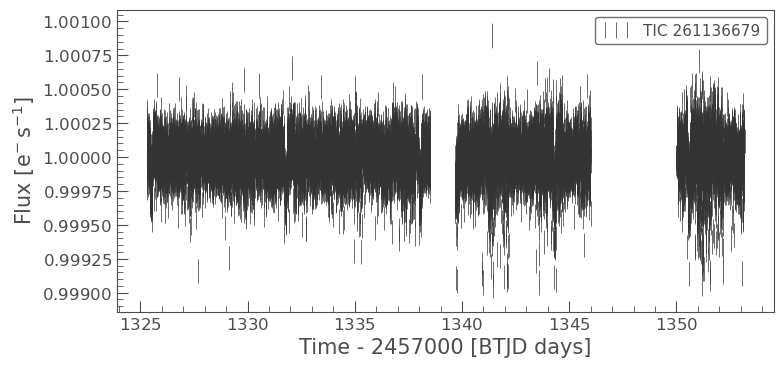

In [70]:
clipped_lc = masked_lc.remove_outliers(sigma=6)
clipped_lc.errorbar()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

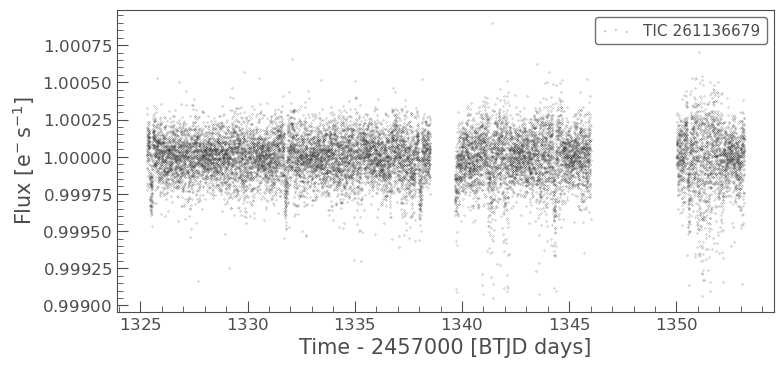

In [72]:
clipped_lc.scatter(s=0.1)

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

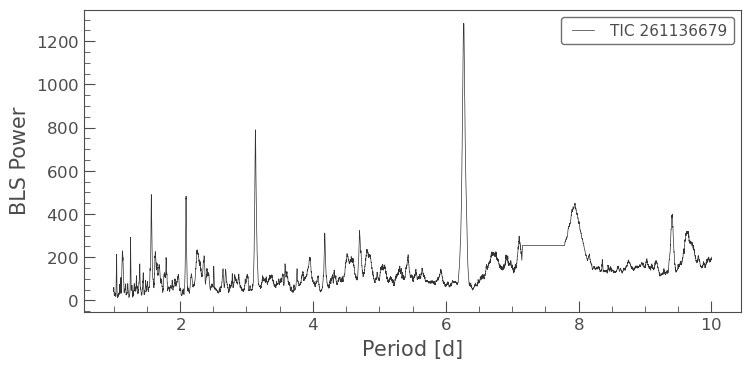

In [73]:
periodogram_lc = clipped_lc.to_periodogram(method="bls", period=np.arange(1, 10, 0.001))
periodogram_lc.plot()

In [75]:
best_fit_period_lc = periodogram_lc.period_at_max_power
print(f"Best fit period: {best_fit_period_lc: .5f}")

Best fit period:  6.27100 d


Notes:
- so the periodic drop happens every 6.271 days

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

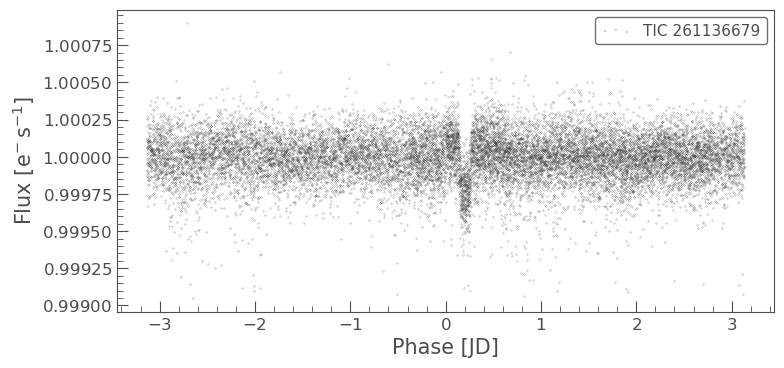

In [76]:
folded_lc = clipped_lc.fold(period=best_fit_period_lc)
folded_lc.scatter(s=0.1)

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

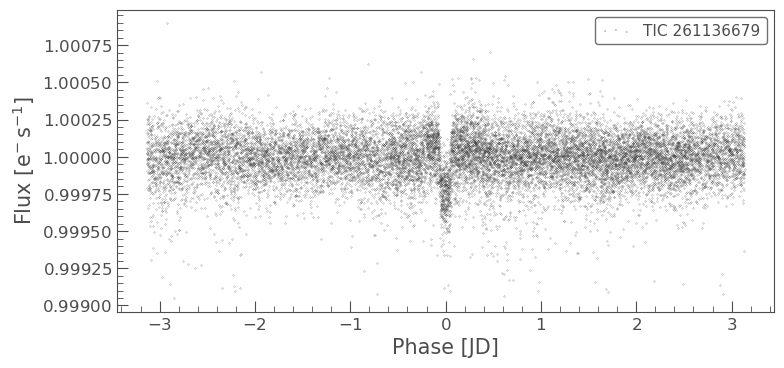

In [89]:
# epoch_time to shift the plot (put the drop at phase 0)
folded_lc = clipped_lc.fold(period=best_fit_period_lc, epoch_time=1325.504)
folded_lc.scatter(s=0.1)

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

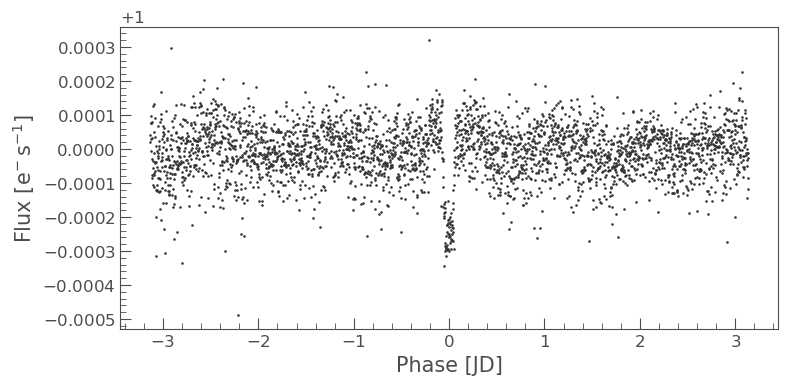

In [91]:
binned_lc = folded_lc.bin(time_bin_size=0.002)
binned_lc.scatter(s=3)

## Look for new planets
Download the data from:
https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html
MAST catalogs > mission: TESS CTL (CTL contains a set of targets likely for TESS transit detection)
For now, there are "Records Found: 9,488,282" stars.
Too many stars, so we'll apply some filters:
In the [tutorial](https://www.youtube.com/watch?v=J2yD9JrqllA), we'll get the stars that have 
- temperature between 4000 and 4500
- distance between 0 and 10 parsec (1 parsec = 3.26 light-years)
=> we get 7 stars

You can copy the ID of a star and check if there is a planet found yet on this website: https://exo.mast.stsci.edu/
You can also google the HIP of the star: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=HIP+113576

To download for example star 79841001, you can search for target "TIC 79841001" in collection "MAST Observations by Object Name or RA/Dec.
However we don't see the star has been analyzed by TESS yet so we should select another star: e.g. "TIC 419012256"
=> download
The downloaded files can have the pixelfiles and also the light curves already computed:
- tess2020238165205-s0029-0000000419012256-0193-s_lc.fits
- tess2020238165205-s0029-0000000419012256-0193-s_tp.fits

In [92]:
from lightkurve import TessTargetPixelFile
# import lightkurve as lk

In [94]:
tpf = TessTargetPixelFile("MAST_2021-04-11T1018/TESS/tess2020238165205-s0029-0000000419012256-0193-s/tess2020238165205-s0029-0000000419012256-0193-s_tp.fits")
tpf

TessTargetPixelFile(TICID: 419012256)

<AxesSubplot:title={'center':'Target ID: 419012256, Cadence: 619765'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

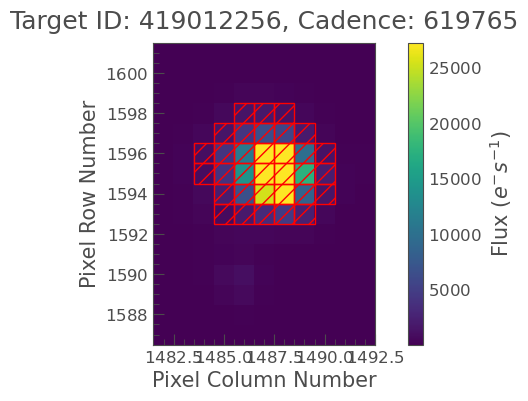

In [95]:
tpf.plot(aperture_mask=tpf.pipeline_mask)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

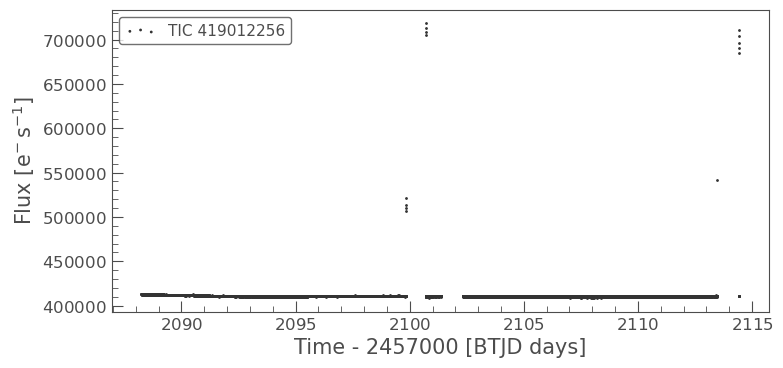

In [109]:
# aperture_mask = tpf.create_threshold_mask(threshold=500)
# lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
lc = tpf.to_lightcurve()
lc.scatter()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

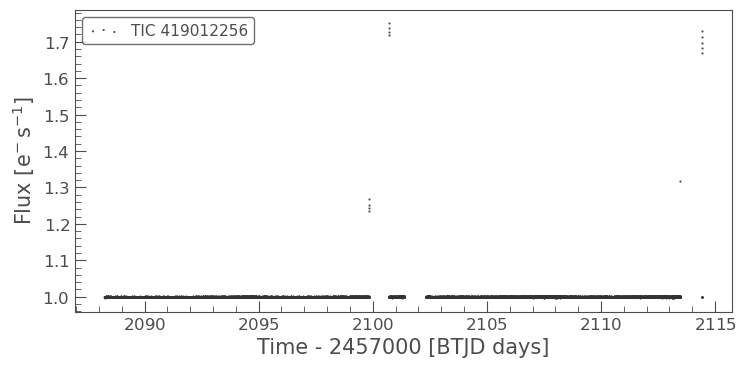

In [110]:
flat_lc = lc.flatten()
flat_lc.scatter(s=1)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

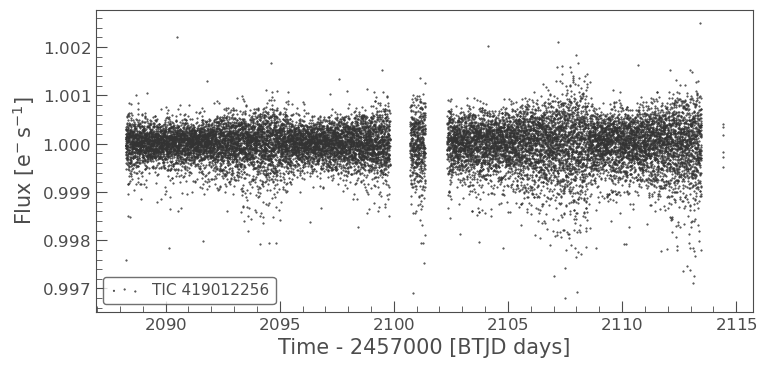

In [134]:
clipped_lc = flat_lc.remove_outliers(sigma=20)
clipped_lc.scatter(s=1)

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

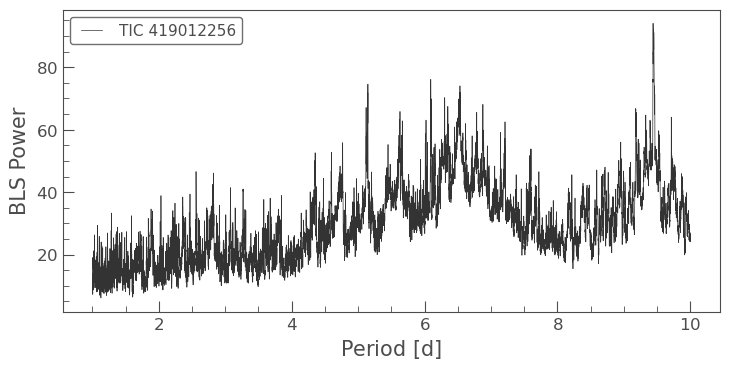

In [135]:
periodogram_lc = clipped_lc.to_periodogram(method="bls", period=np.arange(1, 10, 0.001))
periodogram_lc.plot()

In [136]:
best_fit_period_lc = periodogram_lc.period_at_max_power
print(f"Best fit period: {best_fit_period_lc: .5f}")

Best fit period:  9.44000 d


<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

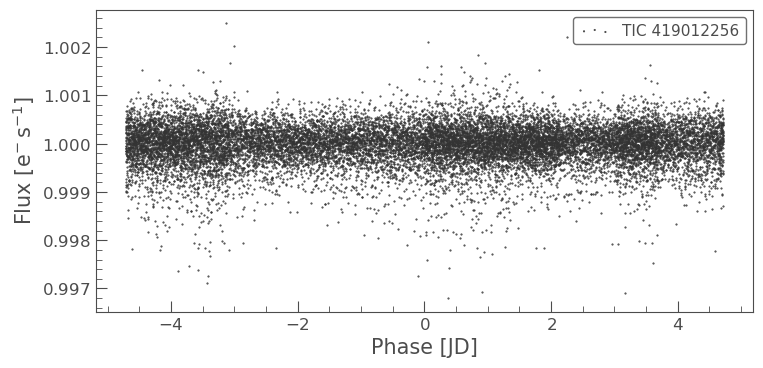

In [137]:
# epoch_time to shift the plot (put the drop at phase 0)
folded_lc = clipped_lc.fold(period=best_fit_period_lc)
folded_lc.scatter(s=1)

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

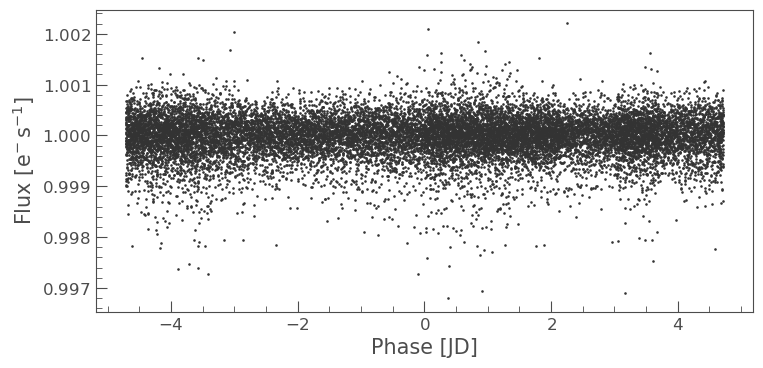

In [138]:
binned_lc = folded_lc.bin(time_bin_size=0.000005)
binned_lc.scatter(s=3)

Notes:
- no sign of a clear passage of a planet
- the brightness variable must be due to the natural variation of the star (there are lot of variable stars)

In [143]:
folded_lc.head()

time,flux,flux_err,time_original,centroid_col,centroid_row,cadenceno,quality
,electron / s,electron / s,,pix,pix,,
object,float64,float64,object,float64,float64,int32,int32
-4.719170158701599,0.9997761399956507,0.00016569011353580749,2092.966254102923,1488.0500558233828,1595.4814990841467,623164,0
-4.718985496515723,1.000237023767747,0.00016575458341544277,2102.406438765108,1488.0161432649415,1595.4515405910686,629961,0
-4.7189660044043675,0.9996100311175521,0.00016597142251192275,2111.8464582572183,1488.1251062443814,1595.3092798377581,636758,0
-4.717781276937256,1.0000660926152467,0.0001657156520680859,2092.9676429846872,1488.048339651768,1595.473457424785,623165,0
-4.717596631981301,0.9990286611622863,0.0001656588695575235,2102.4078276296423,1488.022342223023,1595.4394028684762,629962,0
